In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
file_path = "update_data.csv"
df = pd.read_csv(file_path)
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
num_cols = ['temp_max', 'temp_min', 'temp_avg', 'light_max', 'light_min', 'light_avg',
            'humidity_min', 'humidity_max', 'humidity_avg']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [3]:
# Selecting relevant numerical features
features = ['temp_avg', 'light_avg', 'humidity_avg']
data = df[features]

# Normalize the data for better anomaly detection
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Initialize and fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(data_scaled)

# Convert anomaly labels: -1 (anomaly), 1 (normal) → 1 (anomaly), 0 (normal)
df['Anomaly'] = df['Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Display results
print(df[['Date', 'Time', 'boardid', 'temp_avg', 'light_avg', 'humidity_avg', 'Anomaly']].head())

# Count anomalies
print("Total Anomalies Detected:", df['Anomaly'].sum())

        Date      Time  boardid  temp_avg  light_avg  humidity_avg  Anomaly
0  1/24/2015  10:45:00      510      19.4        0.9          52.7        0
1  1/24/2015  11:15:00      511      19.7       10.6          50.2        0
2  1/24/2015  11:15:00      509      19.7        3.1          57.9        0
3  1/24/2015  11:55:00      509      19.7        3.1          53.7        0
4  1/24/2015  11:55:00      510      18.7        1.0          48.6        0
Total Anomalies Detected: 5657


In [4]:
# Select relevant numerical features
features = ['temp_avg', 'light_avg', 'humidity_avg']
data = df[features]

# Impute missing values with the median (optional)
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(data)

# Feature Engineering: Add rolling mean and std for each feature
data_imputed = pd.DataFrame(data_imputed, columns=features)

# Rolling mean and std for each feature (window size 5 for example)
# Avoid leakage by using min_periods=1
data_imputed['temp_avg_rolling_mean'] = data_imputed['temp_avg'].rolling(window=5, min_periods=1).mean()
data_imputed['light_avg_rolling_mean'] = data_imputed['light_avg'].rolling(window=5, min_periods=1).mean()
data_imputed['humidity_avg_rolling_mean'] = data_imputed['humidity_avg'].rolling(window=5, min_periods=1).mean()

data_imputed['temp_avg_rolling_std'] = data_imputed['temp_avg'].rolling(window=5, min_periods=1).std()
data_imputed['light_avg_rolling_std'] = data_imputed['light_avg'].rolling(window=5, min_periods=1).std()
data_imputed['humidity_avg_rolling_std'] = data_imputed['humidity_avg'].rolling(window=5, min_periods=1).std()

# Drop NaN values created by rolling (they can appear in the first few rows)
data_imputed = data_imputed.dropna()

# Ensure the index aligns with the original DataFrame (df)
df_filtered = df.loc[data_imputed.index]

# Normalize the data for better anomaly detection
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Initialize and fit Isolation Forest (parallelize with n_jobs=-1)
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42, n_jobs=-1)
df_filtered['Anomaly'] = iso_forest.fit_predict(data_scaled)

# Convert anomaly labels: -1 (anomaly), 1 (normal) → 1 (anomaly), 0 (normal)
df_filtered['Anomaly'] = df_filtered['Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Add anomaly scores (lower score means more anomalous)
df_filtered['Anomaly_Score'] = iso_forest.decision_function(data_scaled)

# Display results
print(df_filtered[['Date', 'Time', 'boardid', 'temp_avg', 'light_avg', 'humidity_avg', 'Anomaly']].head())

# Count anomalies
print("Total Anomalies Detected:", df_filtered['Anomaly'].sum())

        Date      Time  boardid  temp_avg  light_avg  humidity_avg  Anomaly
1  1/24/2015  11:15:00      511      19.7       10.6          50.2        0
2  1/24/2015  11:15:00      509      19.7        3.1          57.9        0
3  1/24/2015  11:55:00      509      19.7        3.1          53.7        0
4  1/24/2015  11:55:00      510      18.7        1.0          48.6        0
5  1/24/2015  14:20:00      509      18.7        3.1          59.2        0
Total Anomalies Detected: 5657


In [5]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], format='%m/%d/%Y')
start_date = '2015-01-24'
end_date = '2015-02-24'
filtered_data = df_filtered[(df_filtered['Date'] >= start_date) & (df_filtered['Date'] <= end_date)]

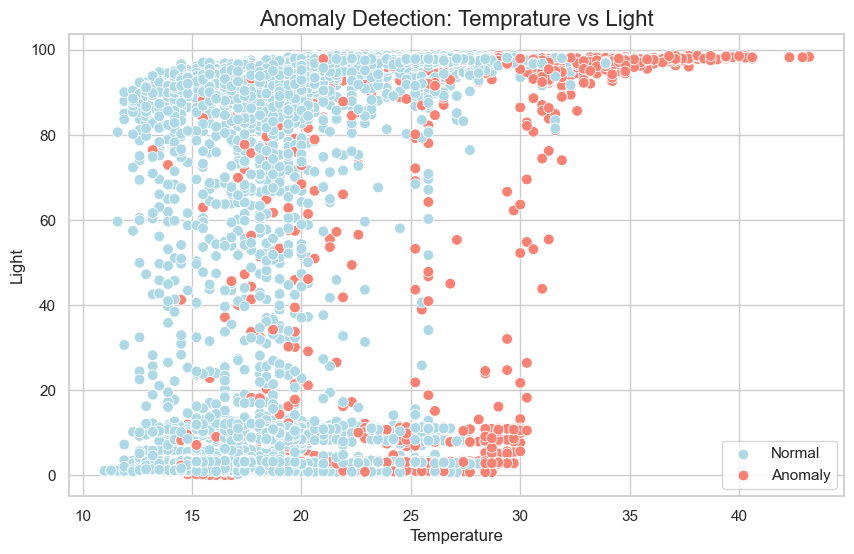

In [21]:
# Anomaly Detection: temp_avg vs light_avg
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_data['temp_avg'], y=filtered_data['light_avg'], 
                hue=filtered_data['Anomaly'], palette={0: 'lightblue', 1: 'salmon'}, 
                style=filtered_data['Anomaly'], markers={0: 'o', 1: 'o'}, s=60)
plt.title('Anomaly Detection: Temprature vs Light', fontsize=16)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Light', fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Normal', 'Anomaly']
plt.legend(handles=handles, labels=labels)
plt.show()

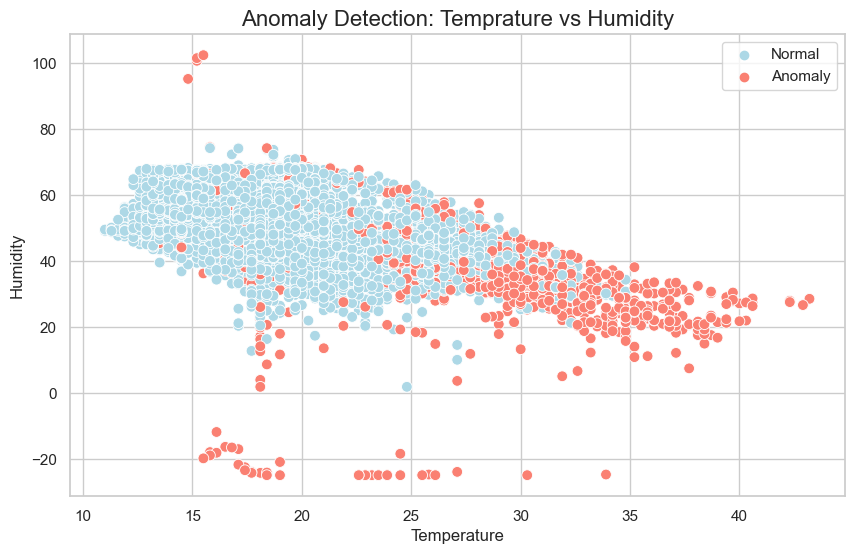

In [20]:
#Anomaly Detection: temp_avg vs light_avg
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_data['temp_avg'], y=filtered_data['humidity_avg'], 
                    hue=filtered_data['Anomaly'], palette={0: 'lightblue', 1: 'salmon'},
                    style=filtered_data['Anomaly'], markers={0: 'o', 1: 'o'}, s=60)
plt.title('Anomaly Detection: Temprature vs Humidity', fontsize=16)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Normal', 'Anomaly']
plt.legend(handles=handles, labels=labels)
plt.show()

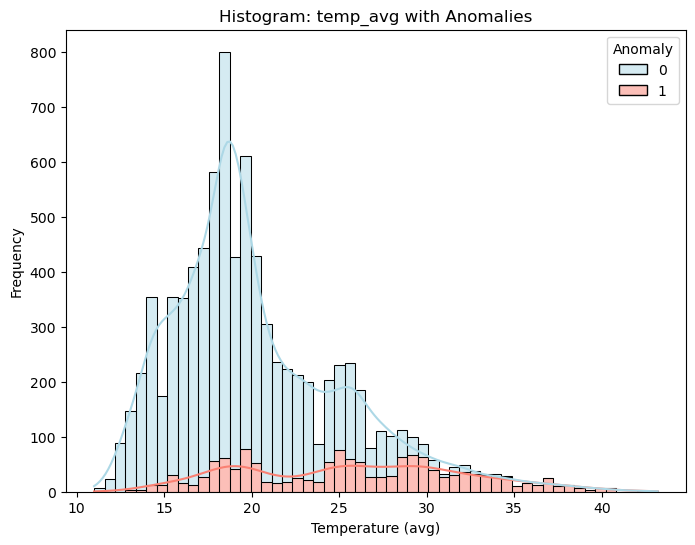

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(filtered_data, x='temp_avg', hue='Anomaly', multiple='stack', palette={0: 'lightblue', 1: 'salmon'}, kde=True)
plt.title('Histogram: temp_avg with Anomalies')
plt.xlabel('Temperature (avg)')
plt.ylabel('Frequency')
plt.show()

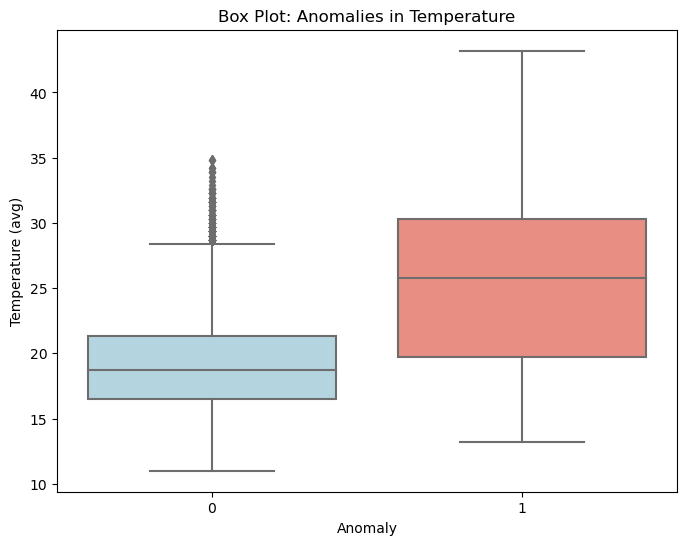

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Anomaly', y='temp_avg', data=filtered_data, palette={0: 'lightblue', 1: 'salmon'})
plt.title('Box Plot: Anomalies in Temperature')
plt.xlabel('Anomaly')
plt.ylabel('Temperature (avg)')
plt.show()

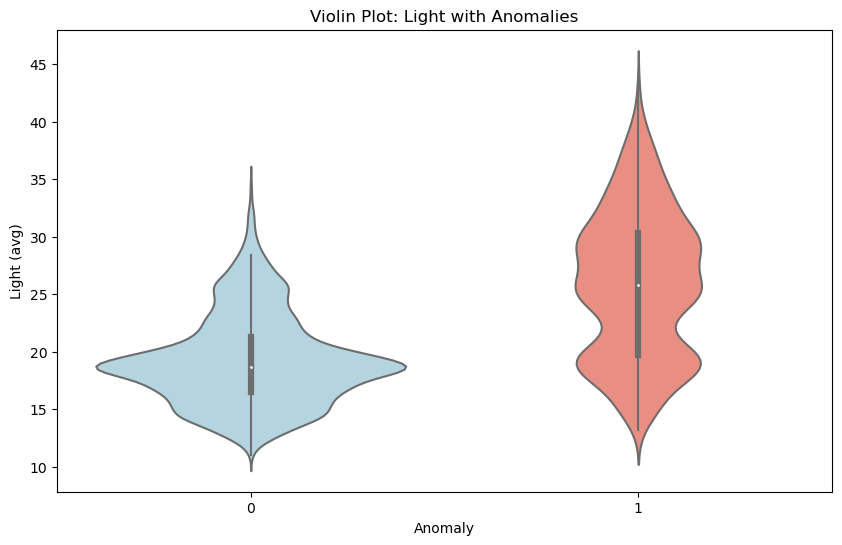

In [10]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Anomaly', y='temp_avg', data=filtered_data, palette={0: 'lightblue', 1: 'salmon'})
plt.title('Violin Plot: Light with Anomalies')
plt.xlabel('Anomaly')
plt.ylabel('Light (avg)')
plt.show()

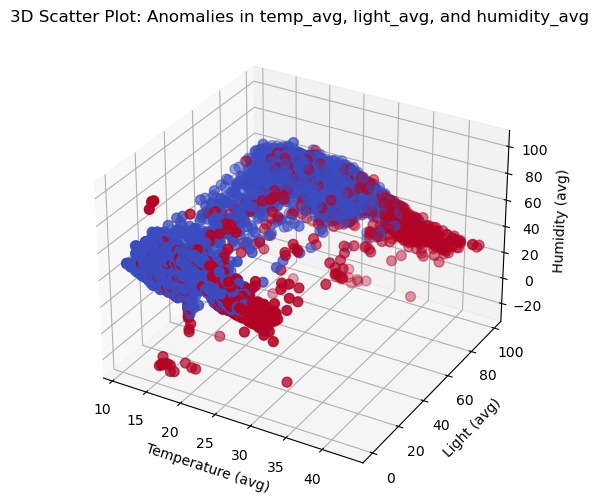

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(filtered_data['temp_avg'], filtered_data['light_avg'], filtered_data['humidity_avg'],
           c=filtered_data['Anomaly'], cmap='coolwarm', s=50)
ax.set_xlabel('Temperature (avg)')
ax.set_ylabel('Light (avg)')
ax.set_zlabel('Humidity (avg)')
plt.title('3D Scatter Plot: Anomalies in temp_avg, light_avg, and humidity_avg')
plt.show()


C:\Users\basud\AppData\Local\Temp\ipykernel_16756\3444944479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['LOF_Anomaly'] = lof.fit_predict(filtered_data[['temp_avg', 'light_avg', 'humidity_avg']])


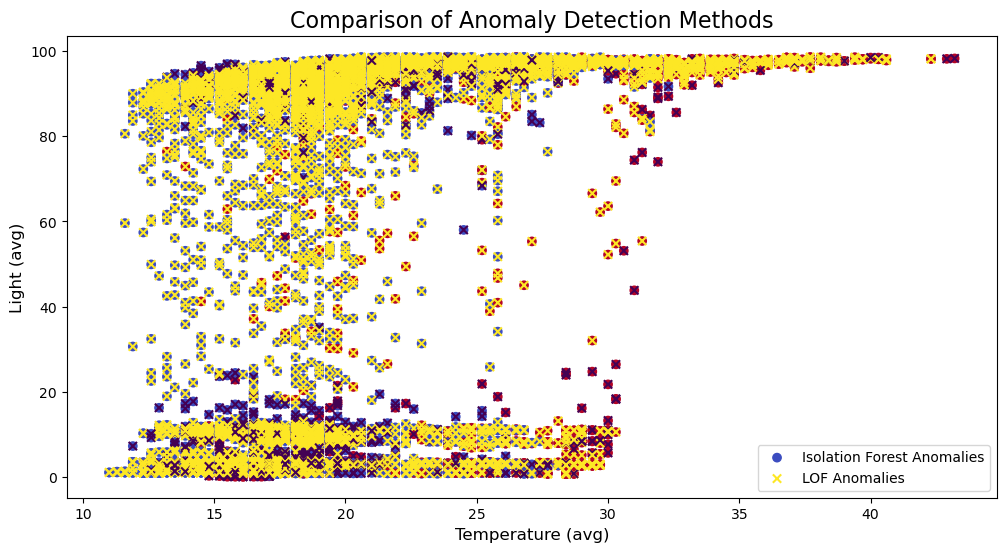

In [12]:
from sklearn.neighbors import LocalOutlierFactor

# Fit LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
filtered_data['LOF_Anomaly'] = lof.fit_predict(filtered_data[['temp_avg', 'light_avg', 'humidity_avg']])

# Compare Isolation Forest and LOF anomalies
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data['temp_avg'], filtered_data['light_avg'], c=filtered_data['Anomaly'], cmap='coolwarm', label='Isolation Forest Anomalies')
plt.scatter(filtered_data['temp_avg'], filtered_data['light_avg'], c=filtered_data['LOF_Anomaly'], cmap='viridis', label='LOF Anomalies', marker='x')
plt.title("Comparison of Anomaly Detection Methods", fontsize=16)
plt.xlabel('Temperature (avg)', fontsize=12)
plt.ylabel('Light (avg)', fontsize=12)
plt.legend()
plt.show()


C:\Users\basud\AppData\Local\Temp\ipykernel_16756\807124218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['True_Anomaly'] = (filtered_data['temp_avg'] > 25).astype(int)  # Just an example


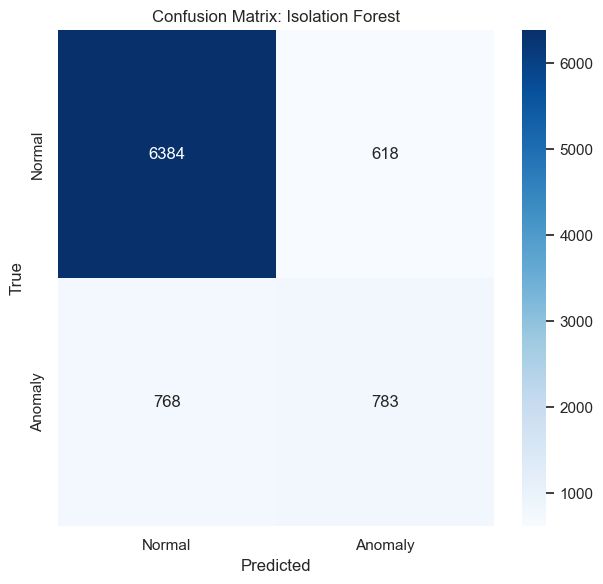

Classification Report: Isolation Forest
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7002
           1       0.56      0.50      0.53      1551

    accuracy                           0.84      8553
   macro avg       0.73      0.71      0.72      8553
weighted avg       0.83      0.84      0.83      8553



In [19]:
# Assuming 'True_Anomaly' is a manually created ground truth column
# If no ground truth, you can simulate this for demonstration purposes

# Example: Assume we manually label some anomalies (this should be your true labels)
# You can replace this with your actual ground truth labels if available.
filtered_data['True_Anomaly'] = (filtered_data['temp_avg'] > 25).astype(int)  # Just an example

# Get confusion matrix for Isolation Forest vs True Anomalies
iso_forest_cm = confusion_matrix(filtered_data['True_Anomaly'], filtered_data['Anomaly'])
lof_cm = confusion_matrix(filtered_data['True_Anomaly'], filtered_data['LOF_Anomaly'])

# Plot Confusion Matrix for Isolation Forest
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(iso_forest_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix: Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('True')

# # Plot Confusion Matrix for LOF
# plt.subplot(1, 2, 2)
# sns.heatmap(lof_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
# plt.title('Confusion Matrix: LOF')
# plt.xlabel('Predicted')
# plt.ylabel('True')

# Show plots
plt.tight_layout()
plt.show()

# Print Classification Report for both methods
print("Classification Report: Isolation Forest")
print(classification_report(filtered_data['True_Anomaly'], filtered_data['Anomaly']))

# print("Classification Report: LOF")
# print(classification_report(df_filtered['True_Anomaly'], df_filtered['LOF_Anomaly']))


In [14]:
# Assuming 'True_Anomaly' is a manually created ground truth column
# Example: Assume we manually label some anomalies (this should be your true labels)
# You can replace this with your actual ground truth labels if available.
filtered_data['True_Anomaly'] = (filtered_data['temp_avg'] > 25).astype(int)  # Just an example

# Get classification report for Isolation Forest
iso_forest_report = classification_report(filtered_data['True_Anomaly'], filtered_data['Anomaly'], output_dict=True)

# Convert classification report to pandas DataFrame for better readability
iso_forest_df = pd.DataFrame(iso_forest_report).transpose()

# Display Classification Report in Table Format
print("Classification Report: Isolation Forest")
print(iso_forest_df)

# Optionally, you can format and display it more clearly
comparison_df = iso_forest_df[['precision', 'recall', 'f1-score']]

print("\nFormatted Classification Report for Isolation Forest")
print(comparison_df)


Classification Report: Isolation Forest
              precision    recall  f1-score      support
0              0.892617  0.911740  0.902077  7002.000000
1              0.558887  0.504836  0.530488  1551.000000
accuracy       0.837952  0.837952  0.837952     0.837952
macro avg      0.725752  0.708288  0.716282  8553.000000
weighted avg   0.832099  0.837952  0.834693  8553.000000

Formatted Classification Report for Isolation Forest
              precision    recall  f1-score
0              0.892617  0.911740  0.902077
1              0.558887  0.504836  0.530488
accuracy       0.837952  0.837952  0.837952
macro avg      0.725752  0.708288  0.716282
weighted avg   0.832099  0.837952  0.834693


C:\Users\basud\AppData\Local\Temp\ipykernel_16756\428241303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['True_Anomaly'] = (filtered_data['temp_avg'] > 25).astype(int)  # Just an example


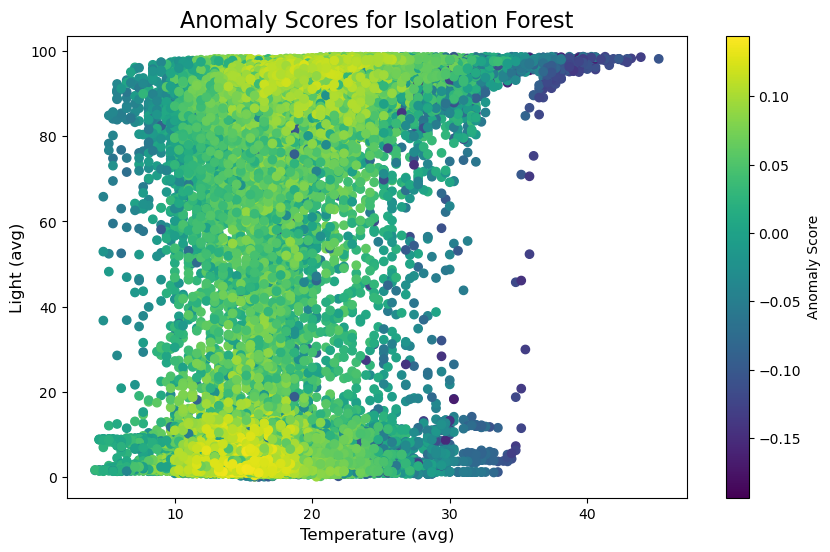

In [15]:
import matplotlib.pyplot as plt

# Add anomaly scores from Isolation Forest
df_filtered['Anomaly_Score'] = iso_forest.decision_function(data_scaled)

# Plot Anomaly Scores
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['temp_avg'], df_filtered['light_avg'], c=df_filtered['Anomaly_Score'], cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.title("Anomaly Scores for Isolation Forest", fontsize=16)
plt.xlabel('Temperature (avg)', fontsize=12)
plt.ylabel('Light (avg)', fontsize=12)
plt.show()

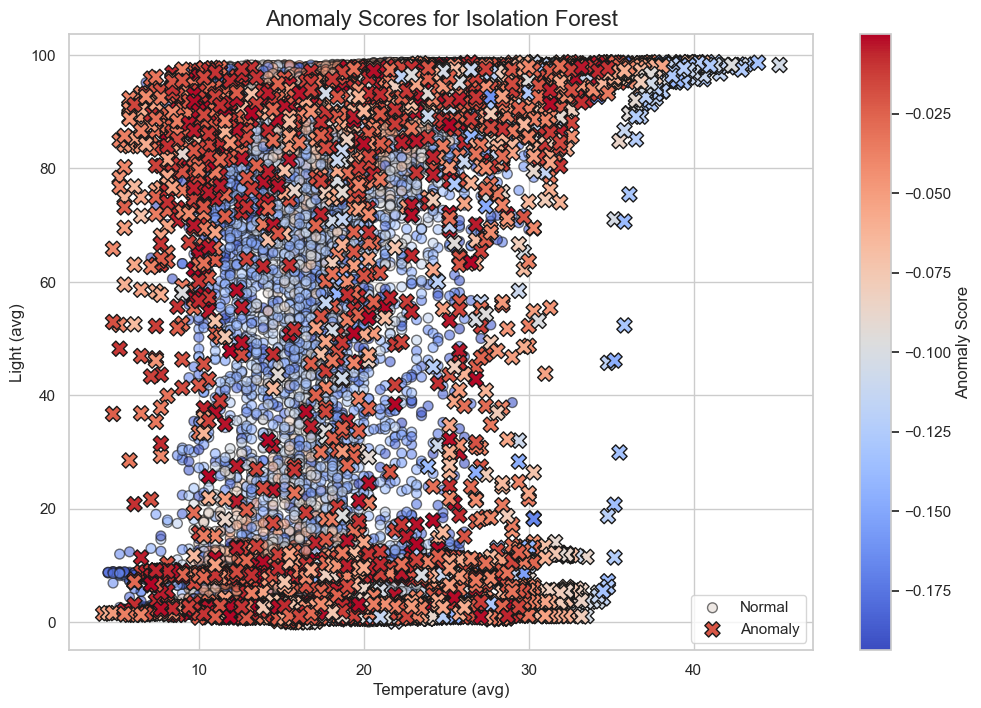

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add anomaly scores from Isolation Forest
df_filtered['Anomaly_Score'] = iso_forest.decision_function(data_scaled)

# Set the figure size and style for better readability
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot Anomaly Scores with better contrast and highlighted anomalies
normal = df_filtered[df_filtered['Anomaly'] == 0]  # Normal data points
anomalies = df_filtered[df_filtered['Anomaly'] == 1]  # Anomalous data points

# Scatter plot for normal data
plt.scatter(normal['temp_avg'], normal['light_avg'], c=normal['Anomaly_Score'], cmap='coolwarm', s=50, edgecolor='k', alpha=0.6, label='Normal')

# Scatter plot for anomalies with larger markers
plt.scatter(anomalies['temp_avg'], anomalies['light_avg'], c=anomalies['Anomaly_Score'], cmap='coolwarm', s=120, edgecolor='k', alpha=1, marker='X', label='Anomaly')

# Add a colorbar for anomaly scores
plt.colorbar(label='Anomaly Score')

# Adding labels and title
plt.title("Anomaly Scores for Isolation Forest", fontsize=16)
plt.xlabel('Temperature (avg)', fontsize=12)
plt.ylabel('Light (avg)', fontsize=12)

# Add a legend
plt.legend()

# Show the plot with grid
plt.grid(True)

# Display the plot
plt.show()


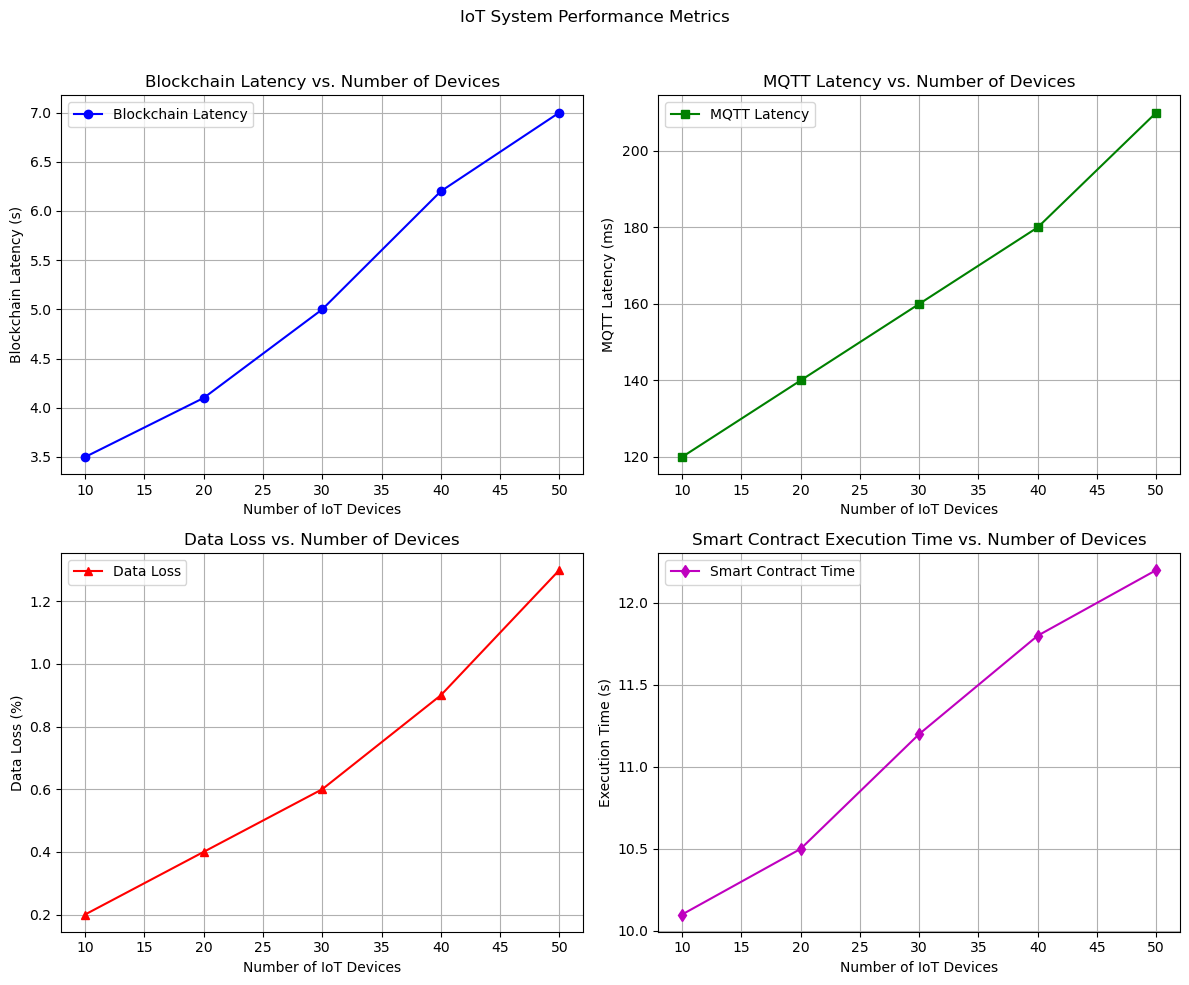

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data for different numbers of IoT devices
devices = np.array([10, 20, 30, 40, 50])

# Blockchain latency (in seconds)
blockchain_latency = np.array([3.5, 4.1, 5.0, 6.2, 7.0])

# MQTT latency (in milliseconds)
mqtt_latency = np.array([120, 140, 160, 180, 210])

# Data loss percentage (%)
data_loss = np.array([0.2, 0.4, 0.6, 0.9, 1.3])

# Smart contract execution time (in seconds)
smart_contract_time = np.array([10.1, 10.5, 11.2, 11.8, 12.2])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("IoT System Performance Metrics")

# Blockchain Latency Plot
axs[0, 0].plot(devices, blockchain_latency, marker='o', linestyle='-', color='b', label="Blockchain Latency")
axs[0, 0].set_xlabel("Number of IoT Devices")
axs[0, 0].set_ylabel("Blockchain Latency (s)")
axs[0, 0].set_title("Blockchain Latency vs. Number of Devices")
axs[0, 0].grid(True)
axs[0, 0].legend()

# MQTT Latency Plot
axs[0, 1].plot(devices, mqtt_latency, marker='s', linestyle='-', color='g', label="MQTT Latency")
axs[0, 1].set_xlabel("Number of IoT Devices")
axs[0, 1].set_ylabel("MQTT Latency (ms)")
axs[0, 1].set_title("MQTT Latency vs. Number of Devices")
axs[0, 1].grid(True)
axs[0, 1].legend()

# Data Loss Plot
axs[1, 0].plot(devices, data_loss, marker='^', linestyle='-', color='r', label="Data Loss")
axs[1, 0].set_xlabel("Number of IoT Devices")
axs[1, 0].set_ylabel("Data Loss (%)")
axs[1, 0].set_title("Data Loss vs. Number of Devices")
axs[1, 0].grid(True)
axs[1, 0].legend()

# Smart Contract Execution Time Plot
axs[1, 1].plot(devices, smart_contract_time, marker='d', linestyle='-', color='m', label="Smart Contract Time")
axs[1, 1].set_xlabel("Number of IoT Devices")
axs[1, 1].set_ylabel("Execution Time (s)")
axs[1, 1].set_title("Smart Contract Execution Time vs. Number of Devices")
axs[1, 1].grid(True)
axs[1, 1].legend()

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


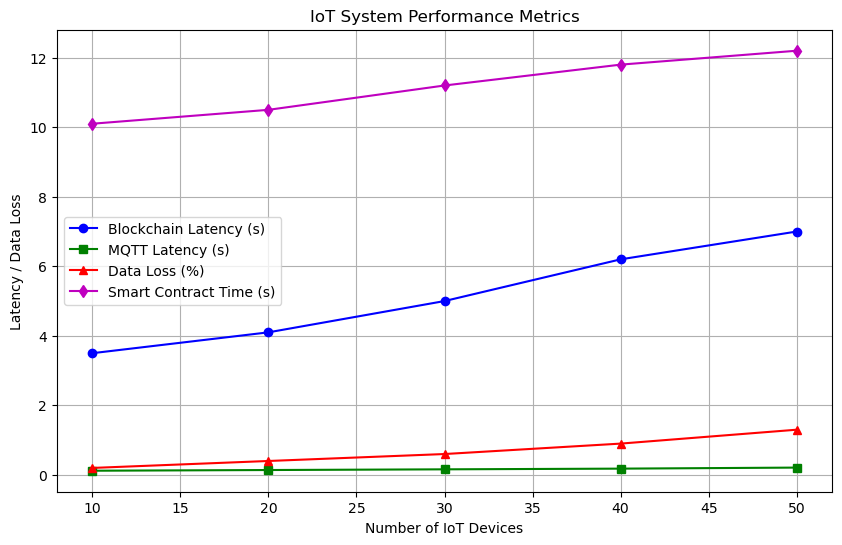

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data for different numbers of IoT devices
devices = np.array([10, 20, 30, 40, 50])

# Blockchain latency (in seconds)
blockchain_latency = np.array([3.5, 4.1, 5.0, 6.2, 7.0])

# MQTT latency (in milliseconds)
mqtt_latency = np.array([120, 140, 160, 180, 210])

# Data loss percentage (%)
data_loss = np.array([0.2, 0.4, 0.6, 0.9, 1.3])

# Smart contract execution time (in seconds)
smart_contract_time = np.array([10.1, 10.5, 11.2, 11.8, 12.2])

# Create a single plot
plt.figure(figsize=(10, 6))
plt.plot(devices, blockchain_latency, marker='o', linestyle='-', color='b', label="Blockchain Latency (s)")
plt.plot(devices, mqtt_latency / 1000, marker='s', linestyle='-', color='g', label="MQTT Latency (s)")
plt.plot(devices, data_loss, marker='^', linestyle='-', color='r', label="Data Loss (%)")
plt.plot(devices, smart_contract_time, marker='d', linestyle='-', color='m', label="Smart Contract Time (s)")

# Labels and title
plt.xlabel("Number of IoT Devices")
plt.ylabel("Latency / Data Loss")
plt.title("IoT System Performance Metrics")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()